# Robust Linear Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

# yahoo finance is used to fetch data 
import yfinance as yf
yf.pdr_override()

In [2]:
# input
symbol = 'AMD'
start = '2014-01-01'
end = '2018-08-27'

# Read data 
dataset = yf.download(symbol,start,end)

# View Columns
dataset.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-01-02,3.85,3.98,3.84,3.95,3.95,20548400
2014-01-03,3.98,4.00,3.88,4.00,4.00,22887200
2014-01-06,4.01,4.18,3.99,4.13,4.13,42398300
2014-01-07,4.19,4.25,4.11,4.18,4.18,42932100
2014-01-08,4.23,4.26,4.14,4.18,4.18,30678700


In [3]:
# Create more data
dataset['Increase_Decrease'] = np.where(dataset['Volume'].shift(-1) > dataset['Volume'],1,0)
dataset['Buy_Sell_on_Open'] = np.where(dataset['Open'].shift(-1) > dataset['Open'],1,-1)
dataset['Buy_Sell'] = np.where(dataset['Adj Close'].shift(-1) > dataset['Adj Close'],1,-1)
dataset['Return'] = dataset['Adj Close'].pct_change()
dataset = dataset.dropna()
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,Increase_Decrease,Buy_Sell_on_Open,Buy_Sell,Return
Date,,,,,,,,,,
2014-01-03,3.98,4.00,3.88,4.00,4.00,22887200,1,1,1,0.012658
2014-01-06,4.01,4.18,3.99,4.13,4.13,42398300,1,1,1,0.032500
2014-01-07,4.19,4.25,4.11,4.18,4.18,42932100,0,1,-1,0.012106
2014-01-08,4.23,4.26,4.14,4.18,4.18,30678700,0,-1,-1,0.000000
2014-01-09,4.20,4.23,4.05,4.09,4.09,30667600,0,-1,1,-0.021531


In [4]:
dataset.shape

(1170, 10)

In [21]:
x1 = dataset['Adj Close']

In [22]:
nsample = 1170
X = np.column_stack((x1, (x1 - 5) ** 2))
X = sm.add_constant(X)
sig = 0.3  # smaller error variance makes OLS<->RLM contrast bigger
beta = [5, 0.5, -0.0]
y_true2 = np.dot(X, beta)
y2 = y_true2 + sig * 1.0 * np.random.normal(size=nsample)
y2[[39, 41, 43, 45, 48]] -= 5  # add some outliers (10% of nsample)

In [23]:
import statsmodels.api as sm

res = sm.OLS(y2, X).fit()
print(res.params)
print(res.bse)
print(res.predict())

[ 4.96811018e+00  5.03727074e-01 -2.77582017e-04]
[0.02667434 0.00523353 0.00062629]
[ 6.98274089  7.04829295  7.07350261 ... 15.42583033 16.1132056
 16.94748893]


In [24]:
resrlm = sm.RLM(y2, X).fit()
print(resrlm.params)
print(resrlm.bse)


[ 5.00467345e+00  5.01424470e-01 -3.24367345e-04]
[0.01899271 0.00372639 0.00044593]


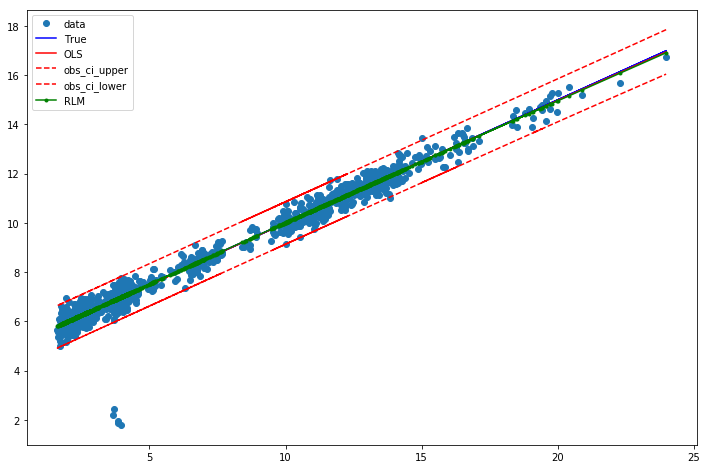

In [25]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
pred_ols = res.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

ax.plot(x1, res.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm.fittedvalues, "g.-", label="RLM")
ax.legend(loc="best")

In [26]:
X2 = X[:, [0, 1]]
res2 = sm.OLS(y2, X2).fit()
print(res2.params)
print(res2.bse)  

[4.97447111 0.50172366]
[0.02247671 0.00263695]


In [27]:
resrlm2 = sm.RLM(y2, X2).fit()
print(resrlm2.params)
print(resrlm2.bse)

[5.01189302 0.49912998]
[0.01596139 0.00187258]


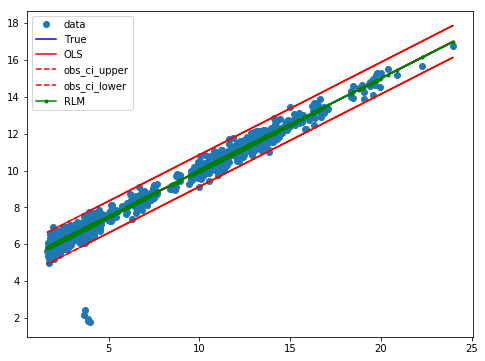

In [28]:
pred_ols = res2.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x1, y2, "o", label="data")
ax.plot(x1, y_true2, "b-", label="True")
ax.plot(x1, res2.fittedvalues, "r-", label="OLS")
ax.plot(x1, iv_u, "r--")
ax.plot(x1, iv_l, "r--")
ax.plot(x1, resrlm2.fittedvalues, "g.-", label="RLM")
legend = ax.legend(loc="best")